In [42]:
%pylab inline

import re
import math
import time
import calendar
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score, KFold

Populating the interactive namespace from numpy and matplotlib


#### Introduction

The goal of the assignment is to analyze the data and identify which factors predict future user adoption. An "adopted user" is defined as a user who has logged into the product on three separate days in at least one sevenday period.

#### Analysis

In [43]:
def convertTimeStamp(data):    
    timestamp = data['last_session_creation_time']
    
    lastsessioncreationtime = datetime.fromtimestamp(timestamp)
    print(lastsessioncreationtime.strftime('%Y-%m-%d %H:%M:%S'))

    return lastsessioncreationtime

In [44]:
def isAdoptedUser(data):    
    vLoginInLast7Days = data['LOGGED']
    
    if vLoginInLast7Days < 3:
        isAdopted = 0
    else:
        isAdopted = 1

    return isAdopted

In [45]:
# Read in the data
df1 = pd.read_csv('takehome_users.csv',encoding='latin-1',parse_dates=True, na_values={''}) #,index_col='object_id')
df2 = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1',parse_dates=True, na_values={''})

In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [47]:
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [48]:
df1['creation_time_utc'] = pd.to_datetime(df1['creation_time'], utc=1)
df1['creation_time_unix'] = df1['creation_time_utc'].astype(np.int64) // 10 ** 9

# Time from account creation to last login
df1['creation_delta'] = (df1['last_session_creation_time'] - df1['creation_time_unix']) / 60000

# Time from account creation to today
df1['lifespan_delta'] = (int(time.time()) - df1['creation_time_unix'])/ 60000

# Time from last login to today
df1['last_login_delta'] = (int(time.time()) - df1['last_session_creation_time'])/ 60000

In [49]:
#delete extra columns
del df1['creation_time'], df1['creation_time_utc'], df1['last_session_creation_time'] #df1['creation_time_unix']

In [50]:
#Rename column names
df1 = df1.rename(index=str, columns={"object_id": "USER_ID", "name": "Name",
                                     "email": "EMAIL", "creation_source": "SOURCE",
                                     "opted_in_to_mailing_list": "OPTED_IN", "enabled_for_marketing_drip": "MKT_ENABLED",
                                     "org_id": "ORGID", "invited_by_user_id": "INVITED_BY",
                                     "creation_delta": "CREATION_DELTA", "lifespan_delta": "LIFESPAN_DELTA",
                                     "last_login_delta": "LAST_LOGIN_DELTA"
                                    })

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
USER_ID               12000 non-null int64
Name                  12000 non-null object
EMAIL                 12000 non-null object
SOURCE                12000 non-null object
OPTED_IN              12000 non-null int64
MKT_ENABLED           12000 non-null int64
ORGID                 12000 non-null int64
INVITED_BY            6417 non-null float64
creation_time_unix    12000 non-null int64
CREATION_DELTA        8823 non-null float64
LIFESPAN_DELTA        12000 non-null float64
LAST_LOGIN_DELTA      8823 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 1.2+ MB


In [52]:
df1.head()

,USER_ID,Name,EMAIL,SOURCE,OPTED_IN,MKT_ENABLED,ORGID,INVITED_BY,creation_time_unix,CREATION_DELTA,LIFESPAN_DELTA,LAST_LOGIN_DELTA
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,1398138810,0.00,2024.496417,2024.496417
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,1384487104,195.84,2252.024850,2056.184850
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,1363734892,0.00,2597.895050,2597.895050
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1369123768,1.44,2508.080450,2506.640450
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,1358417660,7.20,2686.515583,2679.315583


In [53]:
df2 = df2.rename(index=str, columns={"user_id": "USER_ID"})
df2.insert(1, 'DATE_LOGIN', pd.to_datetime(df2['time_stamp']))

del df2['time_stamp'], df2['visited']

df3 = pd.DataFrame(df2.groupby(['USER_ID'], sort=False)['DATE_LOGIN'].max()).reset_index()
df3 = df3.rename(index=str, columns={"DATE_LOGIN": "LAST_LOGIN"})
df3['DATE_FROM'] = df3['LAST_LOGIN'] - timedelta(days=7)

del df3['LAST_LOGIN']

df4 = pd.merge(df3, df2, how='inner', on=['USER_ID'])
df4['LOGGED'] = df4['DATE_LOGIN'] > df4['DATE_FROM']
df4.LOGGED = df4.LOGGED.astype(int)

df5 = pd.DataFrame(df4.groupby(['USER_ID'], sort=False)['LOGGED'].sum()).reset_index()
adoptedUSer = []
adoptedUSer = df5.apply(isAdoptedUser, axis=1)
df5.insert(2, 'ADOPTED', adoptedUSer)

In [54]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 3 columns):
USER_ID    8823 non-null int64
LOGGED     8823 non-null int64
ADOPTED    8823 non-null int64
dtypes: int64(3)
memory usage: 206.9 KB


In [55]:
df5.head()

,USER_ID,LOGGED,ADOPTED
0,1,1,0
1,2,1,0
2,3,1,0
3,4,1,0
4,5,1,0


In [56]:
activity = df1.copy()
users = df5.copy()

In [57]:
useractivity = pd.merge(activity, users, how='inner', on=['USER_ID'])

In [58]:
useractivity.head()

,USER_ID,Name,EMAIL,SOURCE,OPTED_IN,MKT_ENABLED,ORGID,INVITED_BY,creation_time_unix,CREATION_DELTA,LIFESPAN_DELTA,LAST_LOGIN_DELTA,LOGGED,ADOPTED
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,1398138810,0.00,2024.496417,2024.496417,1,0
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,1384487104,195.84,2252.024850,2056.184850,1,0
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,1363734892,0.00,2597.895050,2597.895050,1,0
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1369123768,1.44,2508.080450,2506.640450,1,0
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,1358417660,7.20,2686.515583,2679.315583,1,0


#### Data Exploration

In [59]:
adopteduseractivity = useractivity[useractivity['ADOPTED'] == 1]

In [60]:
nonadopteduseractivity = useractivity[useractivity['ADOPTED'] == 0]

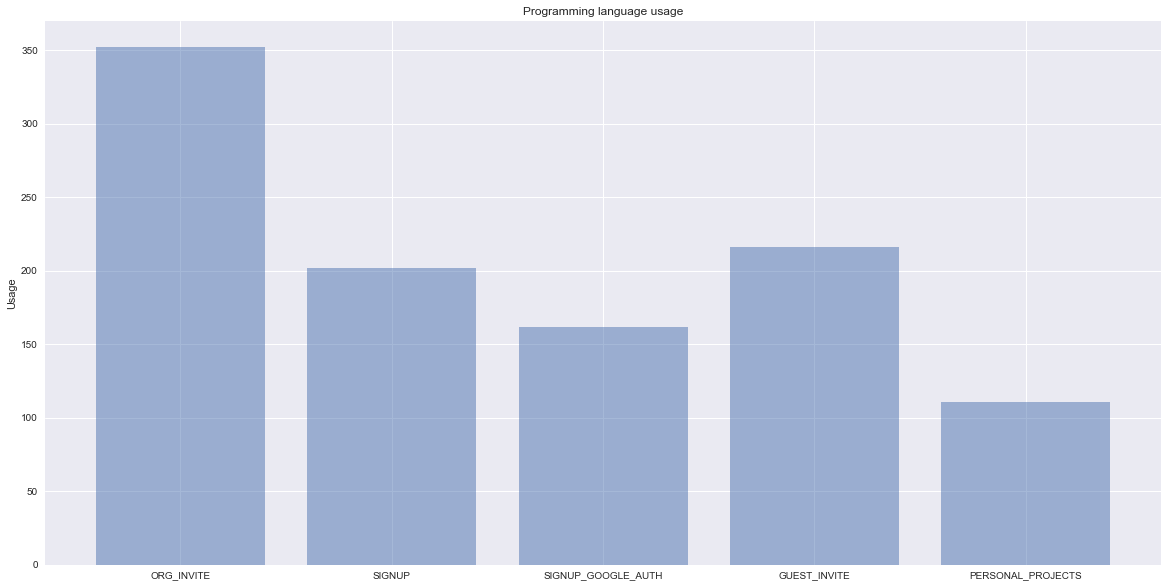

In [61]:
adopteduseractivitydata = pd.DataFrame(adopteduseractivity.groupby(['SOURCE'], sort=False)['ADOPTED'].count()).reset_index()

objects = adopteduseractivitydata.SOURCE
y_pos = np.arange(len(objects))
performance = adopteduseractivitydata.ADOPTED

fig, ax = plt.subplots(figsize=(20, 10))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

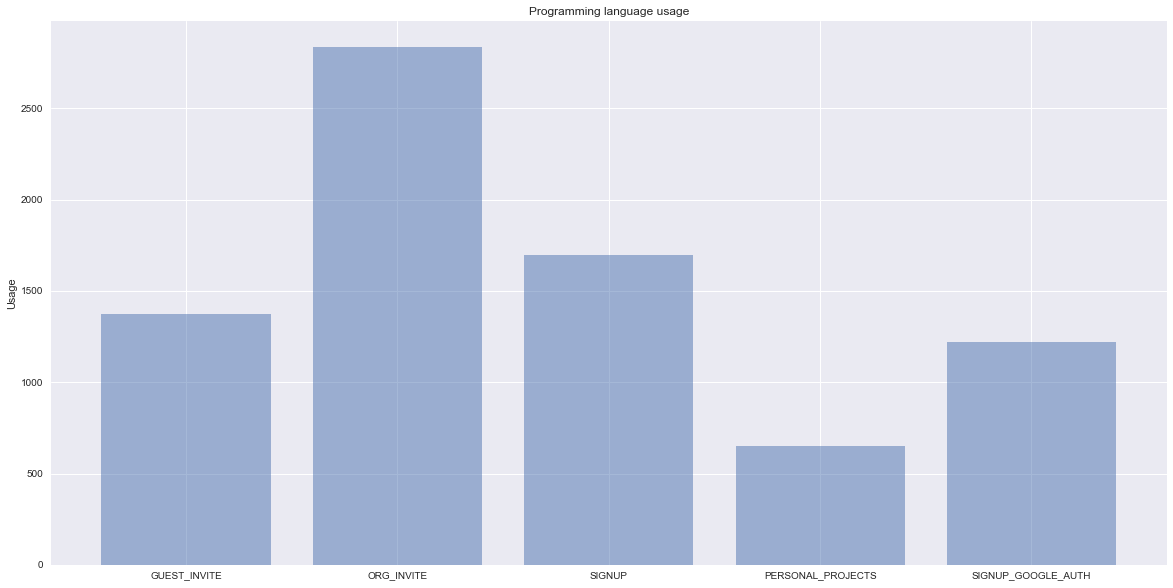

In [62]:
nonadopteduseractivitydata = pd.DataFrame(nonadopteduseractivity.groupby(['SOURCE'], sort=False)['ADOPTED'].count()).reset_index()

objects = nonadopteduseractivitydata.SOURCE
y_pos = np.arange(len(objects))
performance = nonadopteduseractivitydata.ADOPTED

fig, ax = plt.subplots(figsize=(20, 10))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

In [63]:
dfUseractivity = useractivity.copy()

del dfUseractivity['USER_ID'], dfUseractivity['Name'], dfUseractivity['EMAIL']
del dfUseractivity['ORGID'], dfUseractivity['INVITED_BY'], dfUseractivity['creation_time_unix']
del dfUseractivity['LOGGED']

In [64]:
dfUseractivity.head()

,SOURCE,OPTED_IN,MKT_ENABLED,CREATION_DELTA,LIFESPAN_DELTA,LAST_LOGIN_DELTA,ADOPTED
0,GUEST_INVITE,1,0,0.00,2024.496417,2024.496417,0
1,ORG_INVITE,0,0,195.84,2252.024850,2056.184850,0
2,ORG_INVITE,0,0,0.00,2597.895050,2597.895050,0
3,GUEST_INVITE,0,0,1.44,2508.080450,2506.640450,0
4,GUEST_INVITE,0,0,7.20,2686.515583,2679.315583,0


In [65]:
# Look closer at missing values - how many exactly?

for column in list(dfUseractivity.columns):
    num_missing = len(dfUseractivity[dfUseractivity[column].isnull()])
    if num_missing != 0:
        print('There are {} missing values in {}'.format(num_missing, column))

In [66]:
dfUserActivity = pd.get_dummies(dfUseractivity, columns=['SOURCE'])

dfUserActivity.head(5)

,OPTED_IN,MKT_ENABLED,CREATION_DELTA,LIFESPAN_DELTA,LAST_LOGIN_DELTA,ADOPTED,SOURCE_GUEST_INVITE,SOURCE_ORG_INVITE,SOURCE_PERSONAL_PROJECTS,SOURCE_SIGNUP,SOURCE_SIGNUP_GOOGLE_AUTH
0,1,0,0.00,2024.496417,2024.496417,0,1,0,0,0,0
1,0,0,195.84,2252.024850,2056.184850,0,0,1,0,0,0
2,0,0,0.00,2597.895050,2597.895050,0,0,1,0,0,0
3,0,0,1.44,2508.080450,2506.640450,0,1,0,0,0,0
4,0,0,7.20,2686.515583,2679.315583,0,1,0,0,0,0


In [67]:
# Show the correlation matrix
corr_matrix = dfUserActivity.corr()
corr_matrix

,OPTED_IN,MKT_ENABLED,CREATION_DELTA,LIFESPAN_DELTA,LAST_LOGIN_DELTA,ADOPTED,SOURCE_GUEST_INVITE,SOURCE_ORG_INVITE,SOURCE_PERSONAL_PROJECTS,SOURCE_SIGNUP,SOURCE_SIGNUP_GOOGLE_AUTH
OPTED_IN,1.000000,0.488219,0.005609,-0.003153,-0.006590,0.014432,-0.005193,0.011235,-0.005339,0.002632,-0.008198
MKT_ENABLED,0.488219,1.000000,0.007417,-0.003459,-0.008035,-0.002469,-0.007691,0.009502,-0.018095,0.011159,-0.003042
CREATION_DELTA,0.005609,0.007417,1.000000,0.262294,-0.387161,0.766787,0.050775,-0.020841,0.017802,-0.032374,-0.003295
LIFESPAN_DELTA,-0.003153,-0.003459,0.262294,1.000000,0.788180,0.126439,0.018136,-0.006648,0.010459,-0.015159,-0.001337
LAST_LOGIN_DELTA,-0.006590,-0.008035,-0.387161,0.788180,1.000000,-0.368229,-0.015054,0.006940,-0.001361,0.006164,0.000824
ADOPTED,0.014432,-0.002469,0.766787,0.126439,-0.368229,1.000000,0.025838,-0.018171,0.025819,-0.019111,-0.001666
SOURCE_GUEST_INVITE,-0.005193,-0.007691,0.050775,0.018136,-0.015054,0.025838,1.000000,-0.352386,-0.144249,-0.245270,-0.202164
SOURCE_ORG_INVITE,0.011235,0.009502,-0.020841,-0.006648,0.006940,-0.018171,-0.352386,1.000000,-0.231589,-0.393777,-0.324570
SOURCE_PERSONAL_PROJECTS,-0.005339,-0.018095,0.017802,0.010459,-0.001361,0.025819,-0.144249,-0.231589,1.000000,-0.161192,-0.132863
SOURCE_SIGNUP,0.002632,0.011159,-0.032374,-0.015159,0.006164,-0.019111,-0.245270,-0.393777,-0.161192,1.000000,-0.225910


In [68]:
# Filter to see if there are any features correlated at above 0.50 or below -0.50
corr_matrix[(abs(corr_matrix) >= 0.50) & (abs(corr_matrix) < 1.0)]

,OPTED_IN,MKT_ENABLED,CREATION_DELTA,LIFESPAN_DELTA,LAST_LOGIN_DELTA,ADOPTED,SOURCE_GUEST_INVITE,SOURCE_ORG_INVITE,SOURCE_PERSONAL_PROJECTS,SOURCE_SIGNUP,SOURCE_SIGNUP_GOOGLE_AUTH
OPTED_IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MKT_ENABLED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREATION_DELTA,NaN,NaN,NaN,NaN,NaN,0.766787,NaN,NaN,NaN,NaN,NaN
LIFESPAN_DELTA,NaN,NaN,NaN,NaN,0.78818,NaN,NaN,NaN,NaN,NaN,NaN
LAST_LOGIN_DELTA,NaN,NaN,NaN,0.78818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADOPTED,NaN,NaN,0.766787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOURCE_GUEST_INVITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOURCE_ORG_INVITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOURCE_PERSONAL_PROJECTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOURCE_SIGNUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
dfUserActivity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 11 columns):
OPTED_IN                     8823 non-null int64
MKT_ENABLED                  8823 non-null int64
CREATION_DELTA               8823 non-null float64
LIFESPAN_DELTA               8823 non-null float64
LAST_LOGIN_DELTA             8823 non-null float64
ADOPTED                      8823 non-null int64
SOURCE_GUEST_INVITE          8823 non-null uint8
SOURCE_ORG_INVITE            8823 non-null uint8
SOURCE_PERSONAL_PROJECTS     8823 non-null uint8
SOURCE_SIGNUP                8823 non-null uint8
SOURCE_SIGNUP_GOOGLE_AUTH    8823 non-null uint8
dtypes: float64(3), int64(3), uint8(5)
memory usage: 525.6 KB


In [70]:
y = dfUseractivity['ADOPTED']

X = dfUserActivity
del X['ADOPTED']

In [71]:
#Need to normalize due to wide variance between features
lmReg = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lmReg.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lmReg.coef_, index = X.columns, columns = ['estimatedCoefficients']))

lmRegScore = round(lmReg.score(X_test, y_test),2)

print('Test R2 on User Activity by Adopted user using Linear Regression prediction {}'.format(lmRegScore))

lmMseTrnReg = round(np.mean((lmReg.predict(X_train) - y_train) **2),4)
lmMseTstReg = round(np.mean((lmReg.predict(X_test) - y_test) ** 2),4)

print('MSE for training response data: {:.2f}'.format(lmMseTrnReg))
print('MSE for test response data: {:.2f}'.format(lmMseTstReg))

#Using K-folds and cross-validation
kf = KFold(5, shuffle = True)
lmRegCv = LinearRegression(normalize = True)

#Find MSE on response time prediction
scores = cross_val_score(lmRegCv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

                           estimatedCoefficients
OPTED_IN                            1.436007e-02
MKT_ENABLED                        -1.323698e-02
CREATION_DELTA                     -9.456087e+08
LIFESPAN_DELTA                      9.456087e+08
LAST_LOGIN_DELTA                   -9.456087e+08
SOURCE_GUEST_INVITE                 8.492642e+10
SOURCE_ORG_INVITE                   8.492642e+10
SOURCE_PERSONAL_PROJECTS            8.492642e+10
SOURCE_SIGNUP                       8.492642e+10
SOURCE_SIGNUP_GOOGLE_AUTH           8.492642e+10
Test R2 on User Activity by Adopted user using Linear Regression prediction 0.58
MSE for training response data: 0.04
MSE for test response data: 0.04
MSE: 0.04 
SE: 0.00


To predict what factors lead to user adoption I created a multi variable linear regression model. I used an OSL Regression model and following is the table of coefficients of each predictor when regressed against adopted_user, which was a 1 if the user met the criteria for being considered adopted and 0 elsewise. Results are as follows.

In [73]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                ADOPTED   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     1616.
Date:                Sun, 25 Feb 2018   Prob (F-statistic):               0.00
Time:                        20:29:59   Log-Likelihood:                 1438.3
No. Observations:                8823   AIC:                            -2859.
Df Residuals:                    8814   BIC:                            -2795.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Since the creation source variable was a categorical variable, I dummied it out and matched each source against GUEST_INVITE since that creation source type had the highest correlation with adopted_user. We see that the other creation soucres have negative coefficient estimates with our response variable, indicating that GUEST_INVITE is more indicative of adoption than these other sources. When analyzing this further, I created a separate regression of adopted_user against these creation sources.

In [75]:
u = dfUseractivity['ADOPTED']

V = dfUserActivity
del  V['OPTED_IN'], V['MKT_ENABLED'], V['CREATION_DELTA'], V['LAST_LOGIN_DELTA'], V['LIFESPAN_DELTA']

In [76]:
X2 = sm.add_constant(V)
est = sm.OLS(u, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                ADOPTED   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.657
Date:                Sun, 25 Feb 2018   Prob (F-statistic):            0.00556
Time:                        20:30:43   Log-Likelihood:                -2537.3
No. Observations:                8823   AIC:                             5085.
Df Residuals:                    8818   BIC:                             5120.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### Conclusions & Recommendations

In conclusion, from this data the best predictors of future user adoption is our creation_delta variable and the creation source to be GUEST_INVITE. Again, the creation delta variable was constructed as the time from account creation to the user’s last login. Intuitively, this makes sense as users who have been using Asana for a longer span of time are more likely to use the product frequently. As users login more, they are likely to import more information and rely on the platform as a larger part of their day to day tasks, and thus are more likely to be “adopted.” The other predictor variable was creation source as guest invite. Surprisingly personal projects as a creation source did not perform as well as I would have initially thought, but there may be something about the exclusivity and excitement of a friend or colleague inviting you to join the platform
that is inticing.

Thus, conclusions would be as follows: get more guest invites sent and keep users logging in frequently (whether this be via push notification, email, or marketing advertisement).